In [1]:
using Flux
using JLD
using PyPlot

code_path = "../src"

push!(LOAD_PATH, code_path)
using AnomalyDetection

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
x = dataset.data[:,dataset.labels.==0]
y = dataset.labels

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [3]:
# VAE settings
indim = size(x,1)
hiddendim = 10
latentdim = 2
nlayers = 2

# setup the VAE object
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
dsize = [latentdim; hiddendim; hiddendim; indim] # decoder architecture
lambda = 0.001 # KLD weight in loss function
threshold = 0 # classification threshold, is recomputed during fit!()
contamination = size(y[y.==1],1)/size(y, 1) # for automatic threshold computation
iterations = 2000
cbit = 500 # after this number of iteratiosn, callback is printed
verbfit = true
L = 100 # samples for classification
activation = Flux.relu
rdelta = 1e-3 # reconstruction error threshold for training stopping
model = VAEmodel(esize, dsize, lambda, threshold, contamination, iterations, cbit, verbfit, 
    L, activation = activation, rdelta = rdelta)

AnomalyDetection.VAEmodel(AnomalyDetection.VAE{Flux.Chain,AnomalyDetection.#sample_z,Flux.Chain}(Chain(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu)), Dense(10, 4)), AnomalyDetection.sample_z, Chain(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu)), Dense(10, 2))), 0.001, 0, 0.1262135922330097, 2000, 500, true, 100, 0.001)

In [4]:
# fit the model
AnomalyDetection.evalloss(model, x)
AnomalyDetection.fit!(model, x)
AnomalyDetection.evalloss(model, x)

loss: 0.381062
reconstruction error: 0.389495
KL: 0.387688

loss: 0.0477305
reconstruction error: 0.0439522
KL: 1.70539

loss: 0.00563793
reconstruction error: 0.0021419
KL: 3.39722

Training ended prematurely after 1321 iterations,
reconstruction error 0.0009680379481482621 < 0.001
loss: 0.00423295
reconstruction error: 0.000945779
KL: 3.06602



In [5]:
model(x)

Tracked 2×90 Array{Float64,2}:
 0.813312  0.787218  0.841892  0.821998  …  0.0335421  0.0319015  0.0381259
 0.818118  0.795564  0.839566  0.825271     1.03073    0.969583   0.971007 

In [6]:
x

2×90 Array{Float64,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [7]:
AnomalyDetection.mu(model, x)

Tracked 2×90 Array{Float64,2}:
 -1.95935   -1.95991   -1.97315   …   0.686164    0.710361    0.70884  
  0.198435   0.200209   0.200277     -0.0891958  -0.0979872  -0.0993475

In [8]:
AnomalyDetection.sigma(model,x)

Tracked 2×90 Array{Float64,2}:
 0.0716959  0.0710197  0.0711478  0.0689799  …  0.19968   0.192128  0.193996
 0.279206   0.279189   0.277712   0.27312       0.719269  0.710782  0.711616

In [9]:
AnomalyDetection.sample_z(model, x)

Tracked 2×90 Array{Float64,2}:
 -1.95383    -1.91305   -2.10536   …  0.494772  0.381495   0.943261
 -0.0996436   0.655734   0.426655     0.763558  0.257482  -0.11376 

In [10]:
# predict labels
X = dataset.data
y = dataset.labels
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [11]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset.data, dataset.labels, 
    dataset.data, dataset.labels, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 84
  fp = 6
  fn = 0
precision: 0.6842105263157895
recall: 1.0
f1score: 0.8125
equal error rate: 0.03333333333333333

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 84
  fp = 6
  fn = 0
precision: 0.6842105263157895
recall: 1.0
f1score: 0.8125
equal error rate: 0.03333333333333333


In [12]:
using ScikitLearn.Utils: meshgrid

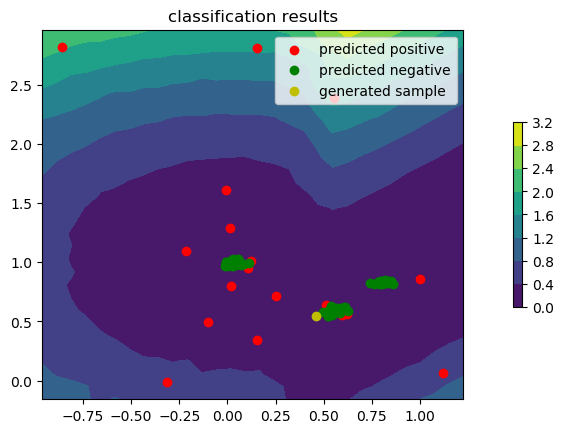

In [13]:
# plot heatmap of the fit
figure()
title("classification results")
scatter(X[1, tstyhat.==1], X[2, tstyhat.==1], c = "r")
ax = gca()
ylim = ax[:get_ylim]()
xlim = ax[:get_xlim]()
xx, yy = meshgrid(linspace(xlim[1], xlim[2], 30), linspace(ylim[1], ylim[2], 30))
zz = zeros(size(xx))
for i in 1:size(xx, 1)
    for j in 1:size(xx, 2)
        zz[i,j] = AnomalyDetection.rerr(model, [xx[i,j], yy[i,j]]).data[1]
    end
end
axsurf = ax[:contourf](xx, yy, zz)
cb = colorbar(axsurf, fraction = 0.05, shrink = 0.5, pad = 0.1)
scatter(X[1, tstyhat.==1], X[2, tstyhat.==1], c = "r", label = "predicted positive")
scatter(X[1, tstyhat.==0], X[2, tstyhat.==0], c = "g", label = "predicted negative")
b = AnomalyDetection.generate(model)
scatter(b[1], b[2], c = "y", label = "generated sample")
legend(loc = "upper right")
show()

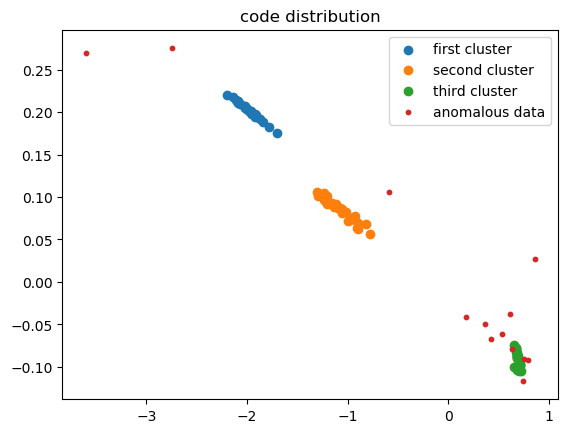

In [14]:
# what are the codes?
figure()
title("code distribution")
z1 = model.vae.encoder(X[:,1:30]).data
z2 = model.vae.encoder(X[:,31:60]).data
z3 = model.vae.encoder(X[:,61:90]).data
za = model.vae.encoder(X[:,91:end]).data

scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 10, label = "anomalous data")
legend()
show()